In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro
from datetime import datetime
import datetime

In [2]:
df = pd.read_csv('ab_data.csv', parse_dates=['timestamp'])
df

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
...,...,...,...,...,...
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0
294477,715931,40:24.5,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0


In [68]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [3]:
df.shape, df.user_id.nunique()

((294480, 5), 290585)

In [67]:
#значения user_id не уникальные
294480-290585

3895

In [4]:
#количество раз, когда в группу эксперимента не попала новая страница, а загрузилась старая версия
df[((df['group']=='treatment') == (df['landing_page']=='new_page')) ==False].shape[0]

3893

- Для корректной дальнейшей работы с данными, создадим новый датафрейм, соответствующий спецификации: 

__группа эксперимента - загружается новая страница.__

In [5]:
df2=df[((df['group']=='treatment') == (df['landing_page']=='new_page')) == True]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [6]:
#проверим еще раз новый датафрейм, не попала ли старая версия страницы в группу эксперимента
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [7]:
#посмотрим сколько уникальных user_id в df2
df2['user_id'].nunique()

290585

In [9]:
#проверим повторяются ли user_id в новом датафрейме
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0


In [10]:
#удалим повторяющиеся user_id
df2.drop_duplicates(['user_id'], inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_21188\1519681218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop_duplicates(['user_id'], inplace=True)


In [11]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted


In [12]:
df2.shape

(290585, 5)

In [68]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


# АВ тестирование по метрике конверсии (converted) в группах

- __Нулевая  гипотеза Н0__ - различий в среднем значении конверсии на новой и старой версии страниц в группе эксперимента и контрольной группе нет.


- __Альтернативная гипотеза Н1__ - есть статистически значимые отличия в средних показателях конверсии в группах эксперимента и контроля.

In [30]:
df_treatment = df2[df2['group']=='treatment']

In [31]:
df_control = df2[df2['group']=='control']

In [69]:
#сравним статистические показатели коверсии в группе эксперимента и контрольной группе
df2.groupby("group").converted.agg(["count", "median", "mean", "std", "max", "min"])

,count,median,mean,std,max,min
group,,,,,,
control,145274,0.0,0.120386,0.325414,1,0
treatment,145311,0.0,0.118807,0.323563,1,0


__В группе эксперимента и контрольной группе нет существенных отличий в показателях конверсии.__

In [49]:
df2.groupby(['group','converted']).size()

group      converted
control    0            127785
           1             17489
treatment  0            128047
           1             17264
dtype: int64

In [47]:
#импортируем необходимые модули
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import scipy.stats as ss
import scipy.stats as sps
from scipy import stats

In [44]:
#проверим на нормальность распределения группу эксперимента (SHAPIRO-WILK TEST)
print(ss.shapiro(df_control.converted.sample(1000, random_state=17)))

ShapiroResult(statistic=0.40198975801467896, pvalue=0.0)


In [45]:
#проверим на нормальность распределения тестовую группу (SHAPIRO-WILK TEST)
print(ss.shapiro(df_treatment.converted.sample(1000, random_state=17)))

ShapiroResult(statistic=0.3536069393157959, pvalue=0.0)


- Полученные p-значения ниже определенного уровня значимости < 0.05, у нас есть достаточно доказательств, чтобы сказать, что данные выборки не получены из нормального распределения. 

- Т.к. значения в интересующем нас показателе "converted" = 1 или 0, преобразовывать данные в нормальное распределение не имеет смысла (логарифм от 0 выдаст ошибку). Проверим гипотезы методом Бутстрап.

In [54]:
#Критерий Манна-Уитни
mannwhitneyu(df_control.converted, df_treatment.converted)
#конверсия и в экспериментальной, и в контрольной группе

MannwhitneyuResult(statistic=10571621978.5, pvalue=0.18965336487086848)

#pvalue > 0.05, делаем вывод, что разницы в средних нет, принимаем Н0

- Нет достаточно доказательств того, что коэффициент конверсии новой страницы выше, чем у старой страницы, количество клиентов в контрольной и экспериментальной группах почти одинаково.


- 12% клиентов контрольной группы были конвертированы и 11,88% пользователей новой страницы конвертировались, в целом коэффициент конверсии старой страницы немного выше, чем у новой, но для подтверждения этого требуется дополнительное тестирование.

__Оценка методом бутстрапа__

In [55]:
test = np.array(df_treatment['converted'])
test.shape

(145311,)

In [56]:
control = np.array(df_control['converted'])
control.shape

(145274,)

In [57]:
array = bs.bootstrap_ab(test = test, ctrl = control
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution = True)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

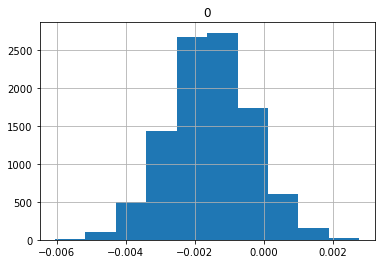

In [58]:
pd.DataFrame(array).hist()

In [59]:
np.percentile(array, 2.5)

-0.003912145813876082

In [60]:
np.percentile(array, 97.5)

0.0007816440907482902

На уровне значимости 5% в данном случае 95% доверительный интервал разности квантилей между группами равен от __-0.0039 до 0.00078__. 
Делаем вывод, что 0 входит в ДИ, значит, __статически значимых отличий между показателями конверсии в экспериментальной и контрольной группах нет.__

In [62]:
from tqdm.notebook import trange, tqdm

In [63]:
#проверим еще одним способом
def get_bootstrap(
    column_1, # числовые значения первой выборки
    column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(column_1), len(column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values

        samples_2 = column_2.sample(
            boot_len, 
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    #Визуализация
    plt.hist(pd_boot_data[0], bins = 50)

    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

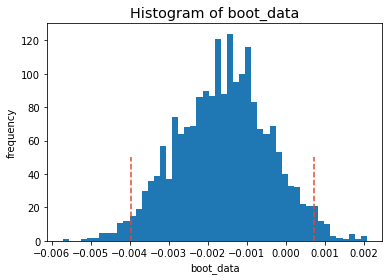

In [64]:
booted_data = get_bootstrap(df_treatment['converted'], df_control['converted'], boot_it = 2000)

In [65]:
booted_data["ci"]

,0
0.025,-0.003971
0.975,0.000730


In [66]:
#получили аналогичные показатели ДИ как в первом способе (-0.0039 и 0.00078)

In [67]:
booted_data["p_value"]

0.1823506330659319

- p-value > 0.05


- 0 принадлежит доверительному интервалу, следовательно, __статистически значимых различий в средних показателях конверсии страниц (между новой и старой версией) в экспериментальной и тестовой группе нет.__


- Подтверждаем нулевую гипотезу Н0.